In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [3]:
import warnings; warnings.simplefilter('ignore')

In [4]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir
from avgn.signalprocessing.create_spectrogram_dataset import flatten_spectrograms
from avgn.visualization.spectrogram import draw_spec_set

### Collect data

In [5]:
DATASET_ID = 'batsong_isolate_segmented'

In [6]:
from avgn.visualization.projections import (
    scatter_projections,
    draw_projection_transitions,
)

In [7]:
df_loc =  DATA_DIR / 'syllable_dfs' / DATASET_ID / 'isolation.pickle'
df_loc

PosixPath('/mnt/cube/tsainbur/Projects/github_repos/avgn_paper/data/syllable_dfs/batsong_isolate_segmented/isolation.pickle')

In [8]:
syllable_df = pd.read_pickle(df_loc)

In [9]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,0.2140,0.3065,0,0,121220031934346505,"[-0.01634356068706672, -0.016108406755690904, ...",250000,"[[0.0, 0.0, 0.0006875495, -0.00013822711, 2.64..."
1,0.3165,0.3360,0,0,121220031934346505,"[-0.046755212954951636, -0.05455942424364232, ...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.02260211, -0.0041..."
2,0.3375,0.3590,0,0,121220031934346505,"[0.04236861015488831, 0.014425384570061723, -0...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.029953696, 0.0087..."


In [10]:
len(syllable_df)

29576

Text(0.5, 1.0, 'min')

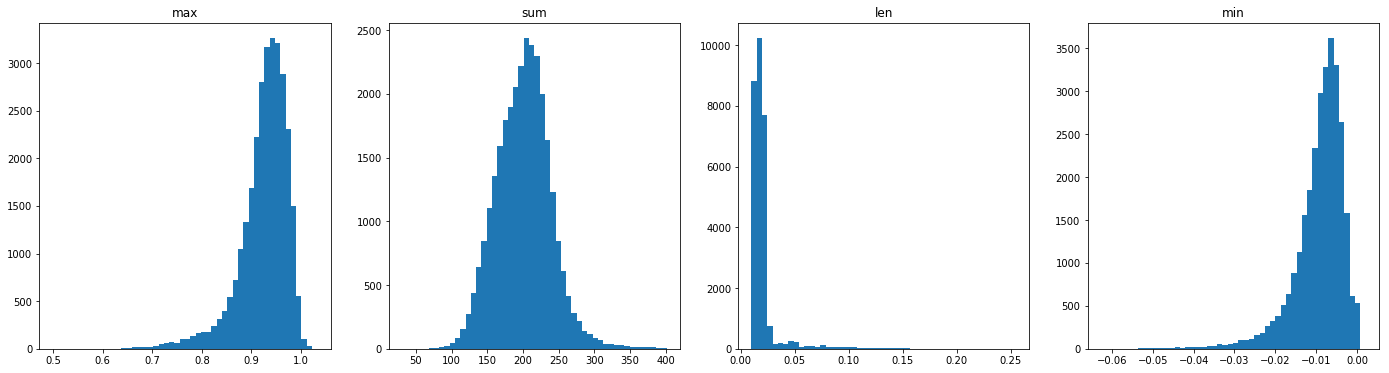

In [11]:
fig, axs = plt.subplots(ncols=4, figsize=(24,6))
axs[0].hist([np.max(i) for i in syllable_df.spectrogram.values], bins=50);axs[0].set_title('max')
axs[1].hist([np.sum(i) for i in syllable_df.spectrogram.values], bins=50);axs[1].set_title('sum')
axs[2].hist((syllable_df.end_time - syllable_df.start_time).values, bins = 50); axs[2].set_title('len')
axs[3].hist([np.min(i) for i in syllable_df.spectrogram.values], bins=50);axs[3].set_title('min')

### cluster

In [12]:
len(syllable_df)

29576

In [13]:
def norm(x):
    return (x-np.min(x)) / (np.max(x) - np.min(x))

In [14]:
specs = list(syllable_df.spectrogram.values)
specs = [norm(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(29576, 1088)

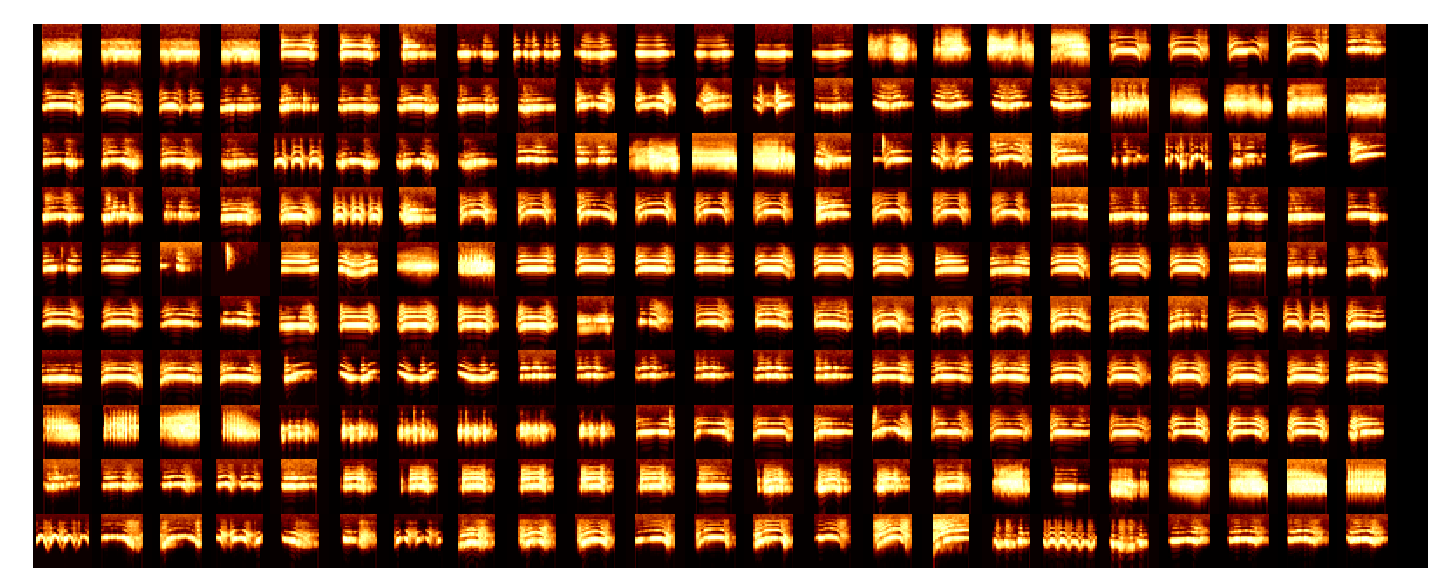

In [15]:
draw_spec_set(specs, zoom=1, maxrows=10, colsize=25)

### cluster

In [16]:
fit = umap.UMAP(min_dist=0.25)

In [17]:
np.shape(specs_flattened)

(29576, 1088)

In [18]:
z  = list(fit.fit_transform(specs_flattened))

In [19]:
z = np.vstack(z)

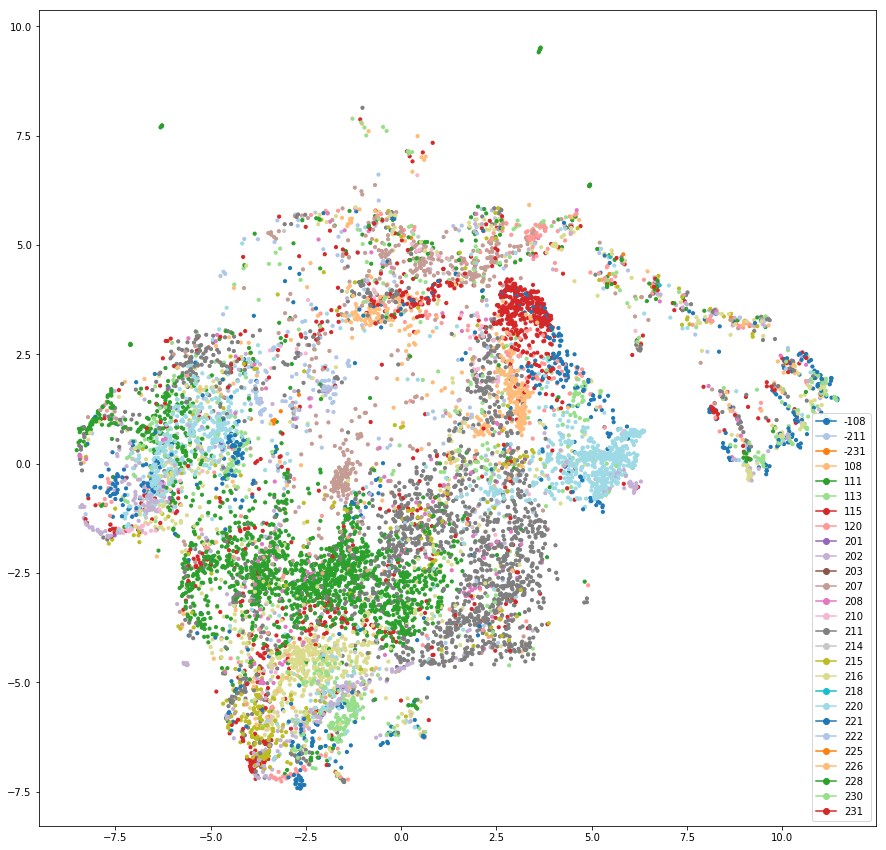

In [20]:
fig, ax = plt.subplots(figsize=(15, 15))
#scatter_projections(projection=z, alpha=0.05, labels=None, s=5, ax=ax)
scatter_projections(
    projection=z[syllable_df.indv.values != "0"],
    alpha=1,
    labels=syllable_df.indv.values[syllable_df.indv.values != "0"],
    s=10,
    ax=ax,
)

# ax.set_xlim([-15,15])

## look at only top indvs

In [21]:
syllable_df[:3]

,start_time,end_time,indv,indvi,key,audio,rate,spectrogram
0,0.2140,0.3065,0,0,121220031934346505,"[-0.01634356068706672, -0.016108406755690904, ...",250000,"[[0.0, 0.0, 0.0006875495, -0.00013822711, 2.64..."
1,0.3165,0.3360,0,0,121220031934346505,"[-0.046755212954951636, -0.05455942424364232, ...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.02260211, -0.0041..."
2,0.3375,0.3590,0,0,121220031934346505,"[0.04236861015488831, 0.014425384570061723, -0...",250000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.029953696, 0.0087..."


In [22]:
top_indvs = (
    pd.DataFrame(
        {i: [np.sum(syllable_df.indv.values == i)] for i in syllable_df.indv.unique()}
    )
    .T.sort_values(by=0, ascending=False)[:15]
    .T
)
top_indvs

,0,111,211,220,216,221,230,115,207,108,202,231,215,120,222
0,18838,1912,1835,1142,859,601,595,594,578,526,421,369,338,278,205


In [23]:
top_indvs.columns[1:]

Index(['111', '211', '220', '216', '221', '230', '115', '207', '108', '202',
       '231', '215', '120', '222'],
      dtype='object')

In [24]:
subset_df = syllable_df[syllable_df.indv.isin(top_indvs.columns[1:])]

In [25]:
len(subset_df)

10253

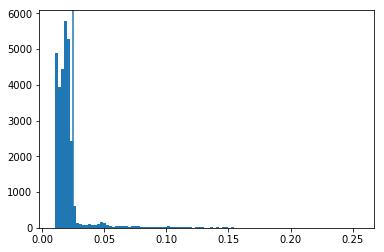

In [26]:
fig,ax=plt.subplots()
ax.hist(np.array(syllable_df.end_time -syllable_df.start_time), bins=100);
ax.axvline(0.025)

In [27]:
subset_df = subset_df[subset_df.end_time - subset_df.start_time < 0.025]

In [28]:
len(subset_df)

9260

In [29]:
specs = list(subset_df.spectrogram.values)
specs = [norm(i) for i in specs]
specs_flattened = flatten_spectrograms(specs)
np.shape(specs_flattened)

(9260, 1088)

In [30]:
fit = umap.UMAP()

np.shape(specs_flattened)

z  = list(fit.fit_transform(specs_flattened))

z = np.vstack(z)

### variation across populations

(-10, 10)

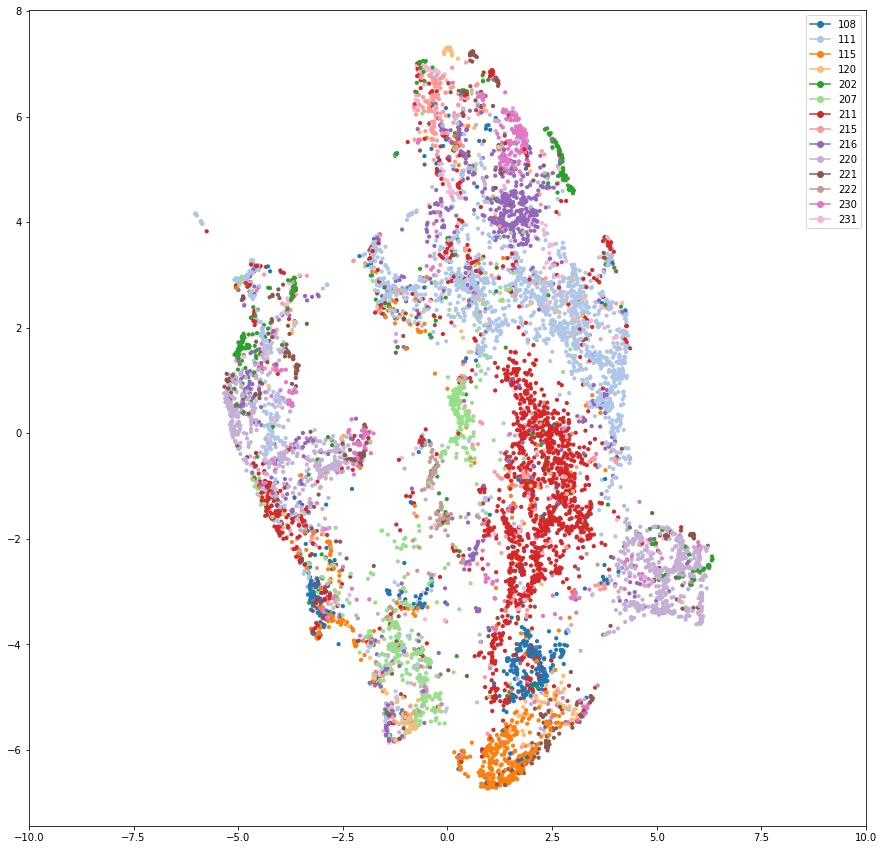

In [31]:
fig, ax = plt.subplots(figsize=(15, 15))
scatter_projections(
    projection=z,
    alpha=1,
    labels=subset_df.indv.values,
    s=10,
    ax=ax,
)

ax.set_xlim([-10,10])